(512, 512, 115)


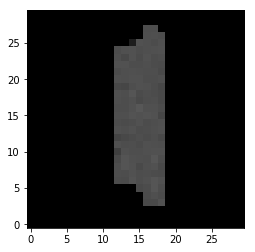

In [250]:
import nibabel
import scipy.misc
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.linalg as npl

class Camera:
    def __init__(self,  position, frame_distance, frame_size, frame_resolution):
        self.position = position
        self.frame_distance = frame_distance
        self.frame_size = frame_size
        self.frame_resolution = frame_resolution


class Ray:

    def __init__(self, i, j, camera):
        self.camera = camera

        frameX = camera.frame_size[0] / camera.frame_resolution[0] * i
        frameY = camera.frame_size[1] / camera.frame_resolution[1] * j
        frameTMP = math.sqrt(frameX ** 2 + frameY ** 2)

        c = math.sqrt(camera.frame_distance ** 2 + frameTMP ** 2)
        self.coefficients = [frameX / c, frameY / c, camera.frame_distance / c]
    def get_world_position(self, v):
        return [v * self.coefficients[0] + camera.position[0],
                     v * self.coefficients[1] + camera.position[1],
                     v * self.coefficients[2] + camera.position[2]]

img = nibabel.load('/home/anya/Documents/sem6/kursach/init_data/case-5eb926ce-b138-4cb6-84f8-f9805724339d/CT_body.nii.gz')
img_data = img.get_fdata()
print(img_data.shape)

voxToWorld = img.affine
worldToVox = npl.inv(voxToWorld)

min_z = -1200

def get_voxel_index(position):
    # voxel size is 1 (no)
    
    result = np.dot(position, worldToVox[:3])
    
    #result[2] *= -1
    
    result[0] += img_data.shape[0] // 2 # x -r
    result[1] += img_data.shape[2] // 2 # y s
    result[2] += img_data.shape[1] // 2 # z -a

    #result[1] *= -1
    #result[0] *= -1
    
    
    if result[0] > 0 and result[1] > 0 and result[2] > 0:
        return [math.floor(result[0]), math.floor(result[2]), math.floor(result[1])]
    else:
        return [-1, -1, -1]

def norm(x):
    min = -1024
    max = 2438
    
    return (x - min) / (max - min)

def get_voxel_color(index):
    # r = math.sqrt(index[0] ** 2 + index[1] ** 2 ) 
    # r = math.sqrt(r ** 2 + index[2] ** 2) * math.sin(index[0] / 10) * 2
    # r = math.sqrt(index[0] ** 2 + index[2] ** 2)

    ''' if index[1] > 25:
        return 0
    return 0.025 if index[1] > r else 0

    return 0.025 if r < 50 else 0 '''

    if index == [-1, -1, -1]:
        return 0

    try:
        value = img_data[tuple(index)]
        if value == -1000:
            return 0 # this is an artificial value for black voxels
        return norm(value)
    except:
        return 0

def ray_trace(ray):
    step = 0.5
    v = 0
    last_voxel_index = [0, 0, 0]
    current_color = 0
    current_opacity = 0
    
    image_started = False

    while True:
        v += step
        voxel_index = get_voxel_index(ray.get_world_position(v))
        if voxel_index == last_voxel_index and voxel_index != [-1, -1, -1]:
            continue
        last_voxel_index = voxel_index
        color = get_voxel_color(voxel_index)
        voxel_color = color
        voxel_opacity = color
        
        color *= 1 - current_opacity
        current_color += color * voxel_opacity
        current_opacity += (1 - current_opacity) * voxel_opacity
        if v > 1300 or current_opacity > 0.99:
            break
        
    return current_color

camera = Camera([0, 0, -900], 300, [200, 200], [30, 30])

drr = np.zeros(camera.frame_resolution)

for i in range(-camera.frame_resolution[0] // 2, camera.frame_resolution[0] // 2):
    for j in range(-camera.frame_resolution[1] // 2, camera.frame_resolution[1] // 2):
        ray = Ray(i, j, camera)
        color = ray_trace(ray)
        #print(color)
        drr[i + camera.frame_resolution[0] // 2, j + camera.frame_resolution[1] // 2] = color


fig, axes = plt.subplots(1, 1)
plt.imshow(drr, cmap="gray", origin="lower", vmin=0, vmax=1)


In [ ]:
plt.imshow(drr, cmap="gray", origin="lower", vmin=0, vmax=1)

In [223]:
plt.savefig('from_side.png')

<Figure size 432x288 with 0 Axes>